In [28]:
import pandas as pd
import os
import fitz  # PyMuPDF
import pandas as pd
import re
from collections import defaultdict
import spacy
import math
pd.set_option('display.max_colwidth', None)
nlp = spacy.load("en_core_web_sm")

In [29]:
def show_common_tokens(resume_name, jd_id, resume_tokens, jd_data):
    if resume_name not in resume_tokens:
        print(f"Resume '{resume_name}' not found.")
        return
    if jd_id not in jd_data:
        print(f"JD ID '{jd_id}' not found.")
        return
    
    r_tokens = resume_tokens[resume_name]
    jd_tokens = jd_data[jd_id]['tokens']
    common = r_tokens.intersection(jd_tokens)
    union = r_tokens.union(jd_tokens)
    
    print(f"\n=== Common Tokens between Resume '{resume_name}' and JD ID {jd_id} ===")
    print(f"=== Resume token length: {len(r_tokens)} and JD token length: {len(jd_tokens)} ===")
    print(f"=== Intersection tokens length: {len(common)} | Union tokens length: {len(union)} ===")
    print(f"Job Title: {jd_data[jd_id]['job_title']}")
    print(f"Jaccard Score: {jaccard_similarity(r_tokens, jd_tokens):.3f}")
    print("Common Tokens (sorted):", sorted(common))
    # for word in sorted(common):
    #     print(f"- {word}")

In [30]:
def print_full_jd(jd_data, jd_id):
    if jd_id not in jd_data:
        print(f"JD ID {jd_id} not found.")
        return
    print(f"\n=== JD ID {jd_id} ===")
    print(f"Job Title: {jd_data[jd_id]['job_title']}")
    print(f"Description:\n{jd_data[jd_id]['full_desc']}")

In [31]:
def extract_text_from_pdf(pdf_path):
    text = ""
    try:
        with fitz.open(pdf_path) as doc:
            for page in doc:
                text += page.get_text()
    except Exception as e:
        print(f"Error reading {pdf_path}: {e}")
    return text

In [32]:
def tokenize(text):
    doc = nlp(text.lower())
    tokens = set()
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.like_num and token.is_alpha:
            tokens.add(token.lemma_)
    return tokens

In [33]:
def jaccard_similarity(set1, set2):
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union) if union else 0

In [34]:
def process_resumes(folder_path):
    resume_data = {}
    for fname in os.listdir(folder_path):
        if fname.endswith('.pdf'):
            full_path = os.path.join(folder_path, fname)
            text = extract_text_from_pdf(full_path)
            tokens = tokenize(text)
            resume_data[fname] = tokens
    return resume_data

In [35]:
def process_job_descriptions(csv_path):
    df = pd.read_csv(csv_path)
    jd_data = {}
    for idx, row in df.iterrows():
        jd_text = str(row['Job Description'])
        tokens = tokenize(jd_text)
        jd_data[idx] = {
            'job_title': row.get('Job Title', ''),
            'tokens': tokens,
            'full_desc': jd_text.strip()
        }
    return jd_data

In [36]:
def match_resumes_to_jobs(resume_tokens, jd_data, top_k=10):
    results = defaultdict(list)
    for resume_name, r_tokens in resume_tokens.items():
        scores = []
        for jd_id, jd_info in jd_data.items():
            score = jaccard_similarity(r_tokens, jd_info['tokens'])
            scores.append((jd_id, score, jd_info['job_title']))
        top_matches = sorted(scores, key=lambda x: -x[1])[:top_k]
        results[resume_name] = top_matches
    return results

In [37]:
jd_csv_path = 'job_title_des.csv'
jd_data = process_job_descriptions(jd_csv_path)

In [38]:
categories = ['INFORMATION-TECHNOLOGY']
base_resume_dir = './resume_pds/data/data'

resume_tokens = {}
for category in categories:
    folder_path = os.path.join(base_resume_dir, category)
    resume_tokens.update(process_resumes(folder_path))

In [39]:
results = match_resumes_to_jobs(resume_tokens, jd_data)

In [40]:
ct = 0
for resume, matches in results.items():
    print(f"\nResume: {resume}")
    for jd_id, score, title in matches:
        print(f"  JD ID: {jd_id} | Title: {title[:40]}... | Score: {score:.3f}")

    ct+=1
    if(ct > 1):
        break


Resume: 18176523.pdf
  JD ID: 580 | Title: Network Administrator... | Score: 0.202
  JD ID: 2146 | Title: Network Administrator... | Score: 0.199
  JD ID: 1271 | Title: Database Administrator... | Score: 0.194
  JD ID: 1846 | Title: Database Administrator... | Score: 0.189
  JD ID: 18 | Title: Database Administrator... | Score: 0.189
  JD ID: 1071 | Title: Database Administrator... | Score: 0.186
  JD ID: 69 | Title: Database Administrator... | Score: 0.186
  JD ID: 1655 | Title: Network Administrator... | Score: 0.186
  JD ID: 552 | Title: Database Administrator... | Score: 0.184
  JD ID: 530 | Title: Network Administrator... | Score: 0.183

Resume: 25857360.pdf
  JD ID: 2169 | Title: Database Administrator... | Score: 0.176
  JD ID: 420 | Title: Database Administrator... | Score: 0.171
  JD ID: 1979 | Title: Database Administrator... | Score: 0.160
  JD ID: 534 | Title: Database Administrator... | Score: 0.158
  JD ID: 1205 | Title: Database Administrator... | Score: 0.156
  JD ID: 

In [41]:
max_score = 0
for resume, matches in results.items():
    for jd_id, score, title in matches:
        max_score = max(max_score, score)

print(max_score)

0.2300194931773879


In [42]:
# After matching resumes and getting resume_tokens and jd_data
# show_common_tokens("20674668.pdf", 1088, resume_tokens, jd_data)

In [43]:
# print_full_jd(jd_data, jd_id=1088)

In [44]:
import matplotlib.pyplot as plt

def plot_jaccard_score_distribution(results_jaccard):
    """Plot histogram of Jaccard similarity scores."""
    all_scores = [score for matches in results_jaccard.values() for _, score, _ in matches]

    plt.figure(figsize=(8, 5))
    plt.hist(all_scores, bins=20, color='skyblue', edgecolor='black')
    plt.title("Jaccard Similarity Score Distribution")
    plt.xlabel("Similarity Score")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig('jaccard_stem_dist.png')

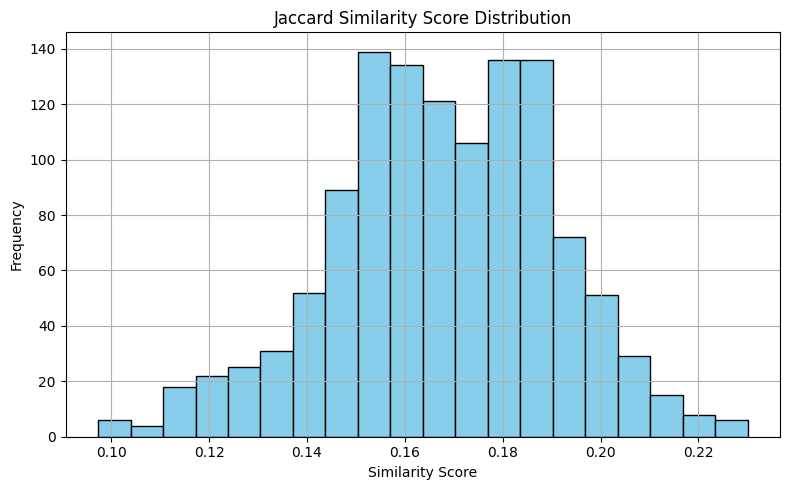

<Figure size 640x480 with 0 Axes>

In [45]:
plot_jaccard_score_distribution(results)

In [46]:
res_df = pd.read_csv('gold_resumes.csv')
jd_df  = pd.read_csv('gold_jds.csv')

In [47]:
gold = {
    "R1": ["J1","J2","J3","J4"],
    "R2": ["J5","J6","J7","J8"],
    "R3": ["J9","J10","J11","J12"],
    "R4": ["J13","J14","J15","J16"],
    "R5": ["J17","J18","J19","J20"],
}

In [48]:
# build token dicts keyed by the raw IDs (“R1”, “R2”, … and “J1”, …)
resume_tokens = {
    row.Resume_ID: tokenize(row.Resume_Text)
    for _, row in res_df.iterrows()
}

In [49]:
jd_data = {
    row.Job_ID: {
       'job_title': row.Job_ID,
       'tokens': tokenize(row.Job_Text),
       'full_desc': row.Job_Text
    }
    for _, row in jd_df.iterrows()
}

In [50]:
results = match_resumes_to_jobs(resume_tokens, jd_data, top_k=4)

In [51]:
# ——— evaluation metrics ———
def precision_at_k(recs, gold_set, k):
    return len(set(recs[:k]) & gold_set) / k

def recall_at_k(recs, gold_set, k):
    return len(set(recs[:k]) & gold_set) / len(gold_set)

def topk_accuracy(recs, gold_set, k):
    return 1.0 if set(recs[:k]) & gold_set else 0.0

def reciprocal_rank(recs, gold_set):
    for i, jid in enumerate(recs, start=1):
        if jid in gold_set:
            return 1.0 / i
    return 0.0

def dcg_at_k(rels, k):
    return sum(r / math.log2(i+1) for i, r in enumerate(rels[:k], start=1))

def ndcg_at_k(recs, gold_set, k):
    rels = [1 if jid in gold_set else 0 for jid in recs[:k]]
    dcg  = dcg_at_k(rels, k)
    ideal = [1] * min(len(gold_set), k)
    idcg = dcg_at_k(ideal, k)
    return dcg / idcg if idcg>0 else 0.0

def evaluate(results, gold, k=4):
    P, R, T, RR, N = [], [], [], [], []
    for rid, ranked in results.items():
        if rid not in gold:
            continue
        gold_set = set(gold[rid])
        # each entry in ranked is (jid, score, title)
        recs = [jid for jid, _, _ in ranked]

        P.append( precision_at_k(recs, gold_set, k) )
        R.append( recall_at_k(recs, gold_set, k)    )
        T.append( topk_accuracy(recs, gold_set, k)  )
        RR.append(reciprocal_rank(recs, gold_set)   )
        N.append( ndcg_at_k(recs, gold_set, k)      )

    return {
        f"Precision@{k}":   sum(P)/len(P),
        f"Recall@{k}":      sum(R)/len(R),
        f"Top-{k} Acc.":    sum(T)/len(T),
        "MRR":              sum(RR)/len(RR),
        f"NDCG@{k}":        sum(N)/len(N),
    }

In [52]:
metrics = evaluate(results, gold, k=4)
for name, val in metrics.items():
    print(f"{name}: {val:.3f}")

Precision@4: 0.700
Recall@4: 0.700
Top-4 Acc.: 1.000
MRR: 1.000
NDCG@4: 0.762
